In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

# Import libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
import evaluate
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Use all available CPU threads
torch.set_num_threads(torch.get_num_threads())

C:\Users\Iverson\anaconda3\envs\captum\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Data Exploration

### Load daaset

In [94]:
df = pd.read_csv('bank_reviews.csv')

### Show 5 rows

In [3]:
df.head(5)

,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,https://static.bankbazaar.com/images/common/ba...,Great!,133
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,89
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,48
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,52
4,R,"Mar 20, 2020",Bangalore,review,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,22


### Plot distribution of mapped Labels

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

In [198]:
mapper = {0:'negative',1:'negative',2:'negative',3:'neutral',4:'positive',5:'positive'}

df['rate'] = df['rating'].astype(int).map(mapper)

In [199]:
df['rate'].value_counts(dropna=False).reset_index()

,rate,count
0,positive,852
1,neutral,92
2,negative,56


### Plot distribution

Text(0.5, 1.0, 'Rating distribution')

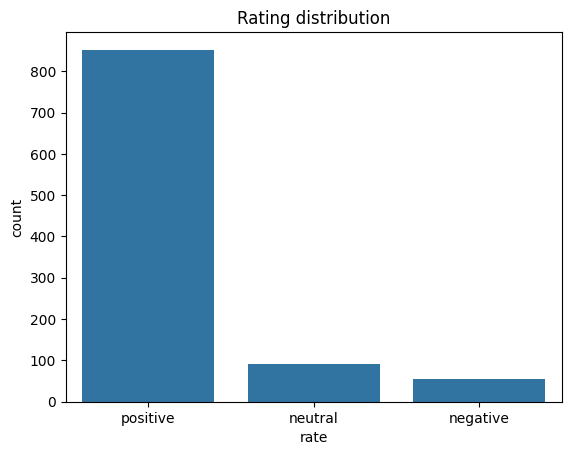

In [200]:
sns.barplot(df['rate'].value_counts().reset_index(),x='rate',y='count')
plt.title('Rating distribution')

### Summarize number of samples and class balance

In [201]:
print('num sample', df.shape)
print('\nclass balance\n', df['rate'].value_counts())

num sample (1000, 12)

class balance
 rate
positive    852
neutral      92
negative     56
Name: count, dtype: int64


# Part 2 Using FinBERT for inference

### load pre-trained FINBERT (yiyanghkust/finbert-tone)

In [202]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load FinBERT (Hugging Face model)
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=3)

### Tokenize Example Senteces

In [203]:
take_5 = df['review'].head(5)

In [204]:
inputs = tokenizer.batch_encode_plus(take_5.values.tolist(),
                                     max_length=128,padding=True,truncation=True,
                                     return_tensors='pt')

### Predict Sentiment Probabilities

In [205]:
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits,dim=1).squeeze()

pred_class = torch.argmax(probs,-1)

In [206]:
labels = ["neutral", "positive","negative"]

#LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

In [207]:
pd.DataFrame(data={
    'text': take_5,
    'sentiment': [labels[i] for i in pred_class]
    },columns=['text','sentiment'])

,text,sentiment
0,State Bank Of India is located nearby in our a...,positive
1,"I have my salary account in SBI, when I applie...",positive
2,I am using Axis bank saving account for the p...,neutral
3,I have my salary bank account in HDFC bank for...,positive
4,"Close to around 10 years, I am holding this Co...",neutral


# Fine Tune FinBERT

In [208]:
label_map = {"neutral": 0, "positive": 1,"negative": 2}
df["label"] = df["rate"].map(label_map)

In [209]:
# Train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["review"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
)

In [210]:
pd.Series(test_labels).value_counts()

1    169
2     16
0     15
Name: count, dtype: int64

In [211]:
train_encodings = tokenizer.batch_encode_plus(train_texts,truncation=True,
                                              max_length=128,padding=True,
                                              return_tensors='pt')

test_encodings = tokenizer.batch_encode_plus(test_texts,truncation=True,
                                              max_length=128,padding=True,
                                              return_tensors='pt')

In [212]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [213]:
train_ds = SentimentDataset(train_encodings,train_labels)
test_ds = SentimentDataset(test_encodings,test_labels)

In [214]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=3)

In [215]:
import evaluate

In [216]:
from sklearn.utils import class_weight
import numpy as np
import torch

In [217]:
# Assuming 'labels' is your array of target class labels
# class_weights_np = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
# class_weights = torch.tensor(class_weights_np, dtype=torch.float)
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# loss = criterion(logits, inputs['labels'])

In [218]:
class_weights

tensor([3.4632, 0.3904, 6.6667])

In [219]:
metric = evaluate.load('accuracy')
class_weights_np = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)
    # criterion = torch.nn.CrossEntropyLoss(weights=class_weights)
    # loss = criterion(logits, inputs['labels'])
    # criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    # loss = criterion(logits, labels)
    # return loss

In [220]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

In [221]:
# ============================================================
# Trainer
# ============================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [222]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.601100,0.732770,0.845000


TrainOutput(global_step=200, training_loss=0.8156840991973877, metrics={'train_runtime': 407.1744, 'train_samples_per_second': 1.965, 'train_steps_per_second': 0.491, 'total_flos': 52622683545600.0, 'train_loss': 0.8156840991973877, 'epoch': 1.0})

In [223]:
save_path = "./models/finbert-financial-sentiment"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"\nModel and tokenizer saved to: {save_path}")


Model and tokenizer saved to: ./models/finbert-financial-sentiment



Classification Report:

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        15
    positive       0.85      0.99      0.92       169
    negative       0.33      0.06      0.11        16

    accuracy                           0.84       200
   macro avg       0.40      0.35      0.34       200
weighted avg       0.75      0.84      0.78       200



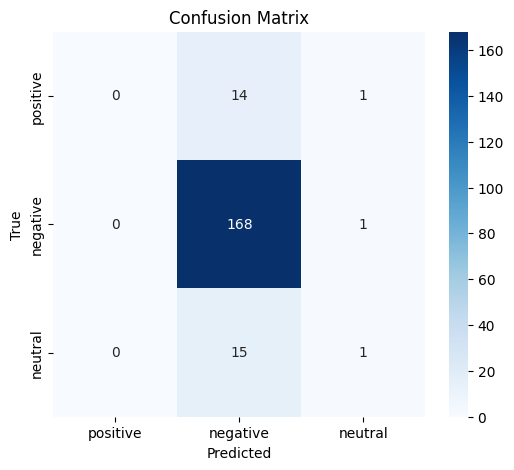

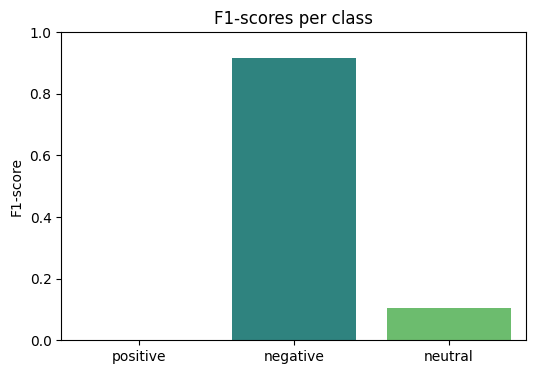

In [224]:
# ============================================================
# Evaluate with detailed metrics
# ============================================================
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids
y_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive", "negative", "neutral"],
            yticklabels=["positive", "negative", "neutral"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Bar chart for F1-scores
report = classification_report(y_true, y_pred, target_names=["positive", "negative", "neutral"], output_dict=True)
f1_scores = [report[label]["f1-score"] for label in ["positive", "negative", "neutral"]]

plt.figure(figsize=(6,4))
sns.barplot(x=["positive", "negative", "neutral"], y=f1_scores, palette="viridis")
plt.title("F1-scores per class")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.show()

# Gradio Apps

In [ ]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import gradio as gr # import gradio

import warnings
warnings.filterwarnings('ignore')

save_path = "./models/finbert-financial-sentiment"

# Load Model
tokenizer = AutoTokenizer.from_pretrained(save_path)
model = AutoModelForSequenceClassification.from_pretrained(save_path)

# Example inference with loaded model
text = "The bank announced late but fine  financial results this quarter."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
pred = torch.argmax(outputs.logits).item()

labels = ["negative", "neutral", "positive"]
print("Predicted Sentiment:", labels[pred])

def response(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits).item()

    return f"Predicted Sentiment: {labels[pred]}" 

demo = gr.Interface(response,'text','text')
demo.launch()

# Explainability

In [225]:
from lime.lime_text import LimeTextExplainer
import waterfall_chart

In [226]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import gradio as gr # import gradio

import warnings
warnings.filterwarnings('ignore')

save_path = "./models/finbert-financial-sentiment"

# Load Model
tokenizer = AutoTokenizer.from_pretrained(save_path)
model = AutoModelForSequenceClassification.from_pretrained(save_path)

In [227]:
explainer = LimeTextExplainer()

sample_text = "The bank reported a strong profit by 70% this quarter."

with torch.no_grad():
    inputs = tokenizer(sample_text, return_tensors="pt")
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    pred = torch.argmax(outputs.logits).item()

#Generate explaination
exp = explainer.explain_instance(sample_text,probs,num_features=10,top_labels=3)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# Get predicted label
label = exp.available_labels()[0]

print('Text:',sample_text)
print('Predicted Label',class_names[label])
print('\nTop contributing words:')
pd.DataFrame(exp.as_list(label=label),columns=['Word','Weight'])